In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Dataset, transforms, and visualisation

Transforming the dataset. Helps in data augmentation in images, in resizing/ cropping/ flipping. 

In [3]:
transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize( (0.5,0.5,0.5), (0.5,0.5,0.5) )
                            # Mean (in x,y,z) and SD in (x,y,z) so that the data varies in similar ranges.                             
])

transform_test = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize( (0.5,0.5,0.5), (0.5,0.5,0.5) )                             
])

In [4]:
trainset = torchvision.datasets.CIFAR10( root = './data', train = True, download = True, transform= transform_train)
testset = torchvision.datasets.CIFAR10( root = './data', train = False, download = True, transform= transform_test)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
num_classes = 10
batch_size = 4

In [6]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True)

In [7]:
dataiter = iter(trainloader)
images, labels= dataiter.next()

print(images.shape)
print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
5


In [8]:
def imshow(img, title):
    npimg = img.numpy() / 2 + 0.5               
    # In the above we un-Normalise the image i.e. first divide by 2 which is same as  multiply by 0.5 to take care of SD, and then adding the mean.
    plt.figure( figsize= (batch_size, 1) )          # Display 4 images in 1 column.
    plt.axis('off')
    plt.imshow( np.transpose(npimg, (1,2,0)) )   # From (RGB, W, H) -> (W, H, RGB)
    plt.title(title)
    plt.show()

In [9]:
def show_batch_images(dataloader):
    images, labels = next( iter(dataloader) )
    img = torchvision.utils.make_grid(images)
    imshow(img, title = [ str(x.item()) for x in labels ] )

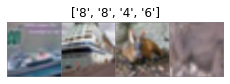

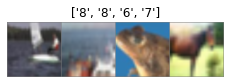

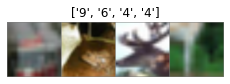

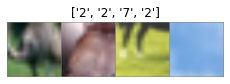

In [10]:
for i in range(4):
    show_batch_images(trainloader)

# Creating VGG-16

Taking the models from PyTorch model zoo. </br>
https://pytorch.org/docs/stable/_modules/torchvision/models/vgg.html#vgg11

In [11]:
from torchvision import models

In [12]:
vgg = models.vgg16_bn()

In [13]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

Extracting the features and then classifying them into different labels.

In [14]:
print(vgg.features[0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [15]:
print(vgg.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


We need to modify to classify into 10 classes instead of 1000 classes (out_features=1000 in VGG classifier layer) that it default supports. 
</br> Instead of modifying it in init params when specifying the model, we are trying to modify the final classifier of VGG itself. 
</br> Directly changing from 'out_features=1000' to 'out_features=10' is not possible since when the model is created 4096 * 1000 weights are initiliased.

In [16]:
final_in_features = vgg.classifier[6].in_features
mod_classifier = list( vgg.classifier.children())[:-1]
mod_classifier.extend( [nn.Linear( final_in_features, num_classes)] )   # Adding our final classifier to the list of Classifiers.
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [17]:
vgg.classifier = nn.Sequential( *mod_classifier)
print(vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)


# Train CIFAR10

In [18]:
batch_size = 16
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [19]:
def evaluation(dataloader, model) :
    total, correct = 0,0 
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
        return 100 * correct / total

In [20]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD( vgg.parameters(), lr = 0.05)

Iteration: 0/3125, Loss: 2.64
Iteration: 100/3125, Loss: 4.15
Iteration: 200/3125, Loss: 2.81
Iteration: 300/3125, Loss: 2.32
Iteration: 400/3125, Loss: 2.24
Iteration: 500/3125, Loss: 2.29
Iteration: 600/3125, Loss: 2.45
Iteration: 700/3125, Loss: 2.38
Iteration: 800/3125, Loss: 2.28
Iteration: 900/3125, Loss: 2.30
Iteration: 1000/3125, Loss: 2.28
Iteration: 1100/3125, Loss: 2.30
Iteration: 1200/3125, Loss: 2.37
Iteration: 1300/3125, Loss: 2.32
Iteration: 1400/3125, Loss: 2.31
Iteration: 1500/3125, Loss: 2.32
Iteration: 1600/3125, Loss: 2.30
Iteration: 1700/3125, Loss: 2.28
Iteration: 1800/3125, Loss: 2.31
Iteration: 1900/3125, Loss: 2.29
Iteration: 2000/3125, Loss: 2.32
Iteration: 2100/3125, Loss: 2.31
Iteration: 2200/3125, Loss: 2.36
Iteration: 2300/3125, Loss: 2.28
Iteration: 2400/3125, Loss: 2.31
Iteration: 2500/3125, Loss: 2.30
Iteration: 2600/3125, Loss: 2.30
Iteration: 2700/3125, Loss: 2.64
Iteration: 2800/3125, Loss: 2.24
Iteration: 2900/3125, Loss: 2.30
Iteration: 3000/3125, 

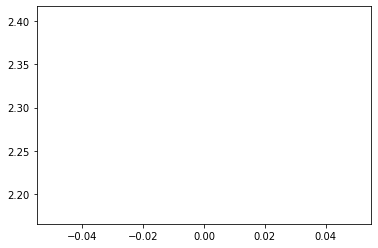

In [21]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/ batch_size)    # No of iterations = Total datapoints / Batch_Size

for epoch in range(max_epochs):
    
    for i, data in enumerate(trainloader, 0):   # Take 1 instance from each batch
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()

        del inputs, labels, outputs         # Deleting Inputs, labels outputs to free up GPU memory after using them and emptying the cache.
        torch.cuda.empty_cache()

        if i%100 == 0:                      # After every 100 iters, printing loss
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
    
    loss_epoch_arr.append(loss.item())

    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, vgg), evaluation(trainloader, vgg)))

plt.plot(loss_epoch_arr)
plt.show()


# Freeze layers of Convolutional Operations

In [22]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [23]:
vgg = models.vgg16_bn(pretrained = True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


In [24]:
for params in vgg.parameters():
    params.requires_grad = False    

Not updating the parameters of the pre-trained model since those are already the best values. We are only updating the weights of the last classification layer as we will be modifying that layer in VGG.

In [25]:
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, num_classes)

Note: first we have set requires_grad = false for all layers. Later when we add new layer, requires_grad = True will be set for the added layer. 
</br>Now only the parameters for the newly added layer will be trained and updated.

In [26]:
for params in vgg.parameters():
    print(params.shape)         # Paramters for all the layers in CNN.

torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512,

In [27]:
for params in vgg.parameters():
    if params.requires_grad :
        print(params.shape)

torch.Size([10, 4096])
torch.Size([10])


In [28]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

Iteration: 0/3125, Loss: 2.34
Iteration: 100/3125, Loss: 1.61
Iteration: 200/3125, Loss: 1.34
Iteration: 300/3125, Loss: 1.43
Iteration: 400/3125, Loss: 1.66
Iteration: 500/3125, Loss: 2.89
Iteration: 600/3125, Loss: 1.66
Iteration: 700/3125, Loss: 2.02
Iteration: 800/3125, Loss: 1.91
Iteration: 900/3125, Loss: 1.58
Iteration: 1000/3125, Loss: 1.94
Iteration: 1100/3125, Loss: 2.55
Iteration: 1200/3125, Loss: 2.21
Iteration: 1300/3125, Loss: 1.91
Iteration: 1400/3125, Loss: 2.24
Iteration: 1500/3125, Loss: 2.20
Iteration: 1600/3125, Loss: 2.75
Iteration: 1700/3125, Loss: 1.88
Iteration: 1800/3125, Loss: 1.91
Iteration: 1900/3125, Loss: 3.51
Iteration: 2000/3125, Loss: 1.66
Iteration: 2100/3125, Loss: 2.06
Iteration: 2200/3125, Loss: 2.27
Iteration: 2300/3125, Loss: 1.92
Iteration: 2400/3125, Loss: 1.75
Iteration: 2500/3125, Loss: 2.84
Iteration: 2600/3125, Loss: 2.14
Iteration: 2700/3125, Loss: 1.46
Iteration: 2800/3125, Loss: 2.93
Iteration: 2900/3125, Loss: 2.82
Iteration: 3000/3125, 

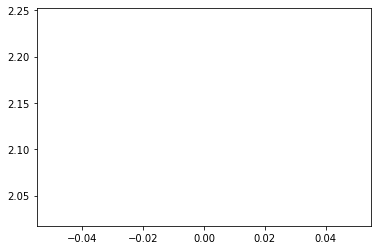

In [29]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/ batch_size)    # No of iterations = Total datapoints / Batch_Size

for epoch in range(max_epochs):
    
    for i, data in enumerate(trainloader, 0):   # Take 1 instance from each batch
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()

        del inputs, labels, outputs         # Deleting Inputs, labels outputs to free up GPU memory after using them and emptying the cache.
        torch.cuda.empty_cache()

        if i%100 == 0:                      # After every 100 iters, printing loss
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
    
    loss_epoch_arr.append(loss.item())

    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, vgg), evaluation(trainloader, vgg)))

plt.plot(loss_epoch_arr)
plt.show()

# Checkpointing with model copies

In [30]:
import copy

In [31]:
loss_epoch_arr = []
max_epochs = 1
min_loss = 1000

n_iters = np.ceil(50000/ batch_size)    # No of iterations = Total datapoints / Batch_Size

for epoch in range(max_epochs):
    
    for i, data in enumerate(trainloader, 0):   # Take 1 instance from each batch
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()

        if loss < min_loss :
            min_loss = loss
            # Copying the entire model and storing in the variable i.e. deepcopy of the model and not the reference.
            best_model = copy.deepcopy( vgg.state_dict() )      
            print("Min Loss : %.2f" %min_loss)

        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
    
    loss_epoch_arr.append(loss.item())

Min Loss : 1.27
Iteration: 0/3125, Loss: 1.27
Min Loss : 1.12
Min Loss : 1.11
Min Loss : 0.80
Iteration: 100/3125, Loss: 1.60
Iteration: 200/3125, Loss: 1.71
Iteration: 300/3125, Loss: 1.56
Min Loss : 0.77
Iteration: 400/3125, Loss: 2.94
Min Loss : 0.74
Min Loss : 0.67
Iteration: 500/3125, Loss: 2.75
Iteration: 600/3125, Loss: 2.19
Iteration: 700/3125, Loss: 1.67
Min Loss : 0.66
Iteration: 800/3125, Loss: 1.93
Iteration: 900/3125, Loss: 2.01
Iteration: 1000/3125, Loss: 2.56
Iteration: 1100/3125, Loss: 3.28
Iteration: 1200/3125, Loss: 1.47
Iteration: 1300/3125, Loss: 1.58
Iteration: 1400/3125, Loss: 1.74
Iteration: 1500/3125, Loss: 2.27
Min Loss : 0.60
Iteration: 1600/3125, Loss: 1.88
Iteration: 1700/3125, Loss: 1.53
Iteration: 1800/3125, Loss: 1.84
Iteration: 1900/3125, Loss: 2.80
Iteration: 2000/3125, Loss: 2.24
Iteration: 2100/3125, Loss: 1.60
Iteration: 2200/3125, Loss: 1.97
Iteration: 2300/3125, Loss: 2.17
Iteration: 2400/3125, Loss: 1.37
Iteration: 2500/3125, Loss: 1.97
Iteration:

In [32]:
vgg.load_state_dict(best_model)
print(evaluation(trainloader, vgg), evaluation(testloader, vgg))

50.0 56.25


# ResNet

https://pytorch.org/docs/stable/_modules/torchvision/models/resnet.html#resnet18

In [33]:
resnet = models.resnet18(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [34]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [35]:
for params in vgg.parameters():
    params.requires_grad = False

In [36]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

In [37]:
for params in vgg.parameters():
    if params.requires_grad == True:
        print(params.shape)

In [38]:
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD( resnet.parameters(), lr = 0.01)

Min loss 2.60
Iteration: 0/3125, Loss: 2.60
Min loss 2.32
Min loss 2.21
Min loss 1.98
Min loss 1.96
Min loss 1.96
Min loss 1.84
Min loss 1.79
Min loss 1.53
Min loss 1.50
Min loss 1.39
Min loss 1.22
Iteration: 100/3125, Loss: 1.70
Min loss 1.13
Min loss 0.95
Min loss 0.87
Min loss 0.85
Iteration: 200/3125, Loss: 1.26
Min loss 0.83
Min loss 0.77
Min loss 0.72
Iteration: 300/3125, Loss: 1.22
Min loss 0.59
Min loss 0.46
Iteration: 400/3125, Loss: 0.92
Min loss 0.42
Iteration: 500/3125, Loss: 1.26
Iteration: 600/3125, Loss: 0.53
Iteration: 700/3125, Loss: 1.02
Iteration: 800/3125, Loss: 0.71
Min loss 0.25
Iteration: 900/3125, Loss: 0.72
Iteration: 1000/3125, Loss: 0.81
Iteration: 1100/3125, Loss: 0.71
Iteration: 1200/3125, Loss: 0.87
Iteration: 1300/3125, Loss: 0.73
Iteration: 1400/3125, Loss: 0.77
Min loss 0.21
Iteration: 1500/3125, Loss: 0.54
Iteration: 1600/3125, Loss: 0.63
Iteration: 1700/3125, Loss: 0.86
Iteration: 1800/3125, Loss: 0.86
Iteration: 1900/3125, Loss: 0.83
Iteration: 2000/

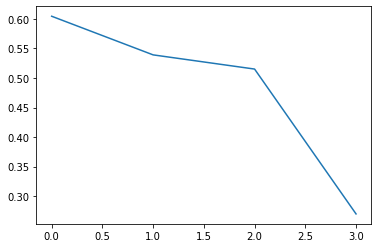

In [39]:
loss_epoch_arr = []
max_epochs = 4

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = resnet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(resnet.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, resnet), evaluation(trainloader, resnet)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

In [40]:
resnet.load_state_dict(best_model)
print(evaluation(trainloader, resnet), evaluation(testloader, resnet))

68.75 68.75


# Inception Model or GoogLeNet

https://pytorch.org/docs/stable/_modules/torchvision/models/inception.html#inception_v3

In [41]:
inception = models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


In [42]:
print(inception)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [43]:
for param in inception.parameters():
    param.requires_grad = False

Should make changes to AuxLogits layer also before making changes to the Final Layer.

In [44]:
aux_in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

In [45]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])


In [46]:
in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, num_classes)

In [47]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])
torch.Size([10, 2048])
torch.Size([10])


Loading modified dataset as Inception model requires 299 X 299 images.

In [48]:
transform_train = transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.ToTensor(),
        transforms.Normalize( (0.5,0.5,0.5), (0.5,0.5,0.5) )
                            # Mean (in x,y,z) and SD in (x,y,z) so that the data varies in similar ranges.                             
])

transform_test = transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.ToTensor(),
        transforms.Normalize( (0.5,0.5,0.5), (0.5,0.5,0.5) )                             
])

In [49]:
trainset = torchvision.datasets.CIFAR10( root = './data', train = True, download = True, transform= transform_train)
testset = torchvision.datasets.CIFAR10( root = './data', train = False, download = True, transform= transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [50]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [51]:
inception = inception.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(inception.parameters(), lr=0.01)

In [52]:
def evaluation_inception(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, aux_outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

Min loss 2.91
Iteration: 0/3125, Loss: 2.91
Min loss 2.89
Min loss 2.88
Min loss 2.86
Min loss 2.81
Min loss 2.62
Iteration: 100/3125, Loss: 2.65
Min loss 2.56
Min loss 2.52
Min loss 2.52
Min loss 2.38
Min loss 2.34
Min loss 2.31
Min loss 2.27
Iteration: 200/3125, Loss: 2.51
Min loss 2.26
Min loss 2.17
Min loss 2.11
Min loss 2.05
Min loss 2.05
Min loss 2.00
Iteration: 300/3125, Loss: 2.47
Min loss 1.99
Min loss 1.98
Iteration: 400/3125, Loss: 2.51
Min loss 1.96
Min loss 1.93
Min loss 1.87
Iteration: 500/3125, Loss: 2.10
Min loss 1.69
Min loss 1.50
Iteration: 600/3125, Loss: 2.27
Iteration: 700/3125, Loss: 1.79
Iteration: 800/3125, Loss: 1.89
Iteration: 900/3125, Loss: 1.89
Min loss 1.49
Iteration: 1000/3125, Loss: 2.03
Min loss 1.40
Min loss 1.38
Iteration: 1100/3125, Loss: 2.06
Iteration: 1200/3125, Loss: 2.36
Min loss 1.18
Iteration: 1300/3125, Loss: 2.20
Iteration: 1400/3125, Loss: 2.12
Iteration: 1500/3125, Loss: 2.13
Min loss 1.04
Iteration: 1600/3125, Loss: 1.88
Iteration: 1700/3

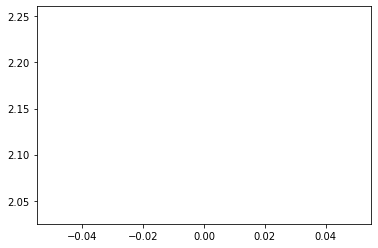

In [53]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        # Combining the 2 losses i.e. Loss for Final and Auxillary outputs. Then, combining the losses with some weights for e.g. 0.3 for Auxillary loss.
        # After combining the losses, backward propogation is done.
        outputs, aux_outputs = inception(inputs)
        loss = loss_fn(outputs, labels) + 0.3 * loss_fn(aux_outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(inception.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation_inception(testloader, inception), evaluation_inception(trainloader, inception)))
    
    
plt.plot(loss_epoch_arr)
plt.show()